# Testing models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
import seaborn as sns

In [2]:
# read in data
zip_file = ZipFile("data/adult23csv.zip")

df_full = pd.read_csv(zip_file.open('adult23.csv'))
y_name = 'LONGCOVD1_A'

In [12]:
def plot_roc(y_true, p_pred, title="ROC"):
    fpr, tpr, thresholds = roc_curve(
        y_true=y_true, y_score=p_pred, pos_label=1, drop_intermediate=False
    )
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots()
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
    x = np.linspace(0,1)
    y = x
    plt.plot(x,y, linestyle='--')
    ax.set(title=title);


- SEX_A : sex
- URBRRL : urban-rural classification
- MARITAL_A : married, living with partner, neither
- ANXEV_A : ever had anxiety disorder
- DEPEV_A : ever had depression
- SHTCVD191_A : was covid vaccinated
- HISPALLP_A : race
- SMKCIGST_A : smoker status
- RATCAT_A : income to poverty threshold (ordinal)
- MEDRXTRT_A : weakened immune system
- EDUCP_A : education level, (ordinal, 97, 99 are NA)
- ARTHEV_A : ever had arthritis

# GENERAL TESTING

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [128]:
feats1 = [
        'BALDIZZ_A',
         'PAIHDFC3M_A',
         'HRLOUDJOB_A',
         'ASEV_A',
         'SEX_A',
         'HYSTEV2_A',
         'PAIAMNT_A',
         'SHTCVD19NM1_A',
         'CFSEV_A',
         "DIBEV_A", 
         "AGEP_A", 
         "BMICAT_A", 
         "COGMEMDFF_A", 
         "SHTCVD191_A", 
         "SHOTTYPE2_A", 
         "HISPALLP_A"
        ]
feats2 = ["MARSTAT_A",
"SASPPRACE_A",
"SPOUSWRK_A",
"MEDICAID_A",
"AFVET_A",
"EMPSICKLV_A",
"PAILLMB3M_A",
"HOUTENURE_A",
"CHIP_A",
"SPOUSLIV_A",
"PAIBACK3M_A",
"HITLOOK_A",
"EQUIP_A",
"VISIONDF_A",
"TRANSPOR_A",
"MILITARY_A",
"REPSTRAIN_A",
"SHTCVD19NM1_A"]

feats = list(set(feats1 + feats2))

feats = ['MHRX_A',
 'PAILLMB3M_A',
 'PAIULMB3M_A',
 'FDSCAT3_A',
 'ANXLEVEL_A',
 'PAIWKLM3M_A',
 'EMERG12MTC_A',
 'DISCRIM3_A',
 'PHQ43_A',
 'PHQ44_A',
 'PAIBACK3M_A',
 'PHQ41_A',
 'FDSCAT4_A',
 'FDSRUNOUT_A',
 'BALDIZZ_A',
 'PAIAMNT_A',
 'PAIFRQ3M_A',
 'PHQ42_A',
 'PAIAPG3M_A',
 'DEPFREQ_A',
 'PAITOOTH3M_A',
 'DEPLEVEL_A',
 'PAIAFFM3M_A',
 'PAIHDFC3M_A']

encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
y_name = 'LONGCOVD1_A'

# drop rows without target
df = df_full.dropna(subset=y_name)
df = df[df[y_name] != 9]

# Subset to columns
bayes_df = df[feats]

if "HYSTEV2_A" in feats:
    # Assume missing hyterectomy values are 'no'
    bayes_df['HYSTEV2_A'].loc[bayes_df['HYSTEV2_A'].isna()] = 2
    
# Put missing pain into separate category, '0'
bayes_df[bayes_df.isna()] = 0
# Data type: int
bayes_df = bayes_df.astype(int)

if np.any(bayes_df.apply(np.unique).apply(len) > 15):
    scaler = StandardScaler().set_output(transform="pandas")

    X = bayes_df.copy()
    
    # define continuous and categorical features
    continuous = X.columns[X.apply(np.unique).apply(len) > 15] 
    categorical = X.columns[~X.columns.isin(continuous)]
    
    # scale and encode
    cont_df =  scaler.fit_transform(X.loc[:, continuous])
    cat_df = encoder.fit_transform(X.loc[:,categorical])
    
    processed_df = pd.concat((cont_df, cat_df), axis=1)
else:
    processed_df = encoder.fit_transform(bayes_df)

X = processed_df.copy()
y = df.loc[:, y_name]
y = (y == 1) * 1 # encode as 0 / 1 values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)

In [129]:
coords = {"coeffs":X_train.columns}

with pm.Model(coords=coords) as gen_model:
    # data containers
    X = pm.Data("X", X_train.values)
    y = pm.Data("y", y_train)
    # priors
    b0 = pm.Normal("b0", 0, 100) # intercept: no shrinkage
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    # linear model
    mu = b0 + pm.math.dot(X, b)
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)
gen_model



 b0 ~ Normal(0, 100)
  b ~ Normal(0, 1)
  p ~ Deterministic(f(b, b0))
obs ~ Bernoulli(p)

In [130]:
with gen_model:
    idata_gen = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [131]:
az.summary(idata_gen, var_names="b")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b[MHRX_A_1]      -0.010  0.162  -0.313    0.288      0.002    0.001    6911.0   
b[MHRX_A_2]      -0.039  0.066  -0.165    0.084      0.001    0.001    7439.0   
b[MHRX_A_7]       0.521  0.650  -0.685    1.746      0.008    0.006    6081.0   
b[MHRX_A_8]      -0.316  0.805  -1.762    1.251      0.010    0.007    6953.0   
b[MHRX_A_9]      -0.165  0.681  -1.478    1.077      0.008    0.005    7727.0   
...                 ...    ...     ...      ...        ...      ...       ...   
b[PAIHDFC3M_A_3]  0.376  0.408  -0.379    1.149      0.005    0.003    7007.0   
b[PAIHDFC3M_A_4]  0.167  0.410  -0.578    0.959      0.005    0.003    7198.0   
b[PAIHDFC3M_A_7] -0.317  0.813  -1.858    1.164      0.009    0.007    7773.0   
b[PAIHDFC3M_A_8] -0.089  0.793  -1.608    1.389      0.009    0.006    7924.0   
b[PAIHDFC3M_A_9] -0.182  0.835  -1.752    1.361      0.010    0.007    6629.0   

                  ess_tail  r_hat  
b[MHRX_A_1]         7773.0   1.00  
b[MHRX_A_2]         8030.0   1.00  
b[MHRX_A_7]         7882.0   1.00  
b[MHRX_A_8]         7694.0   1.01  
b[MHRX_A_9]         8105.0   1.00  
...                    ...    ...  
b[PAIHDFC3M_A_3]    7185.0   1.01  
b[PAIHDFC3M_A_4]    7569.0   1.01  
b[PAIHDFC3M_A_7]    7905.0   1.00  
b[PAIHDFC3M_A_8]    8099.0   1.00  
b[PAIHDFC3M_A_9]    7685.0   1.01  

[143 rows x 9 columns]

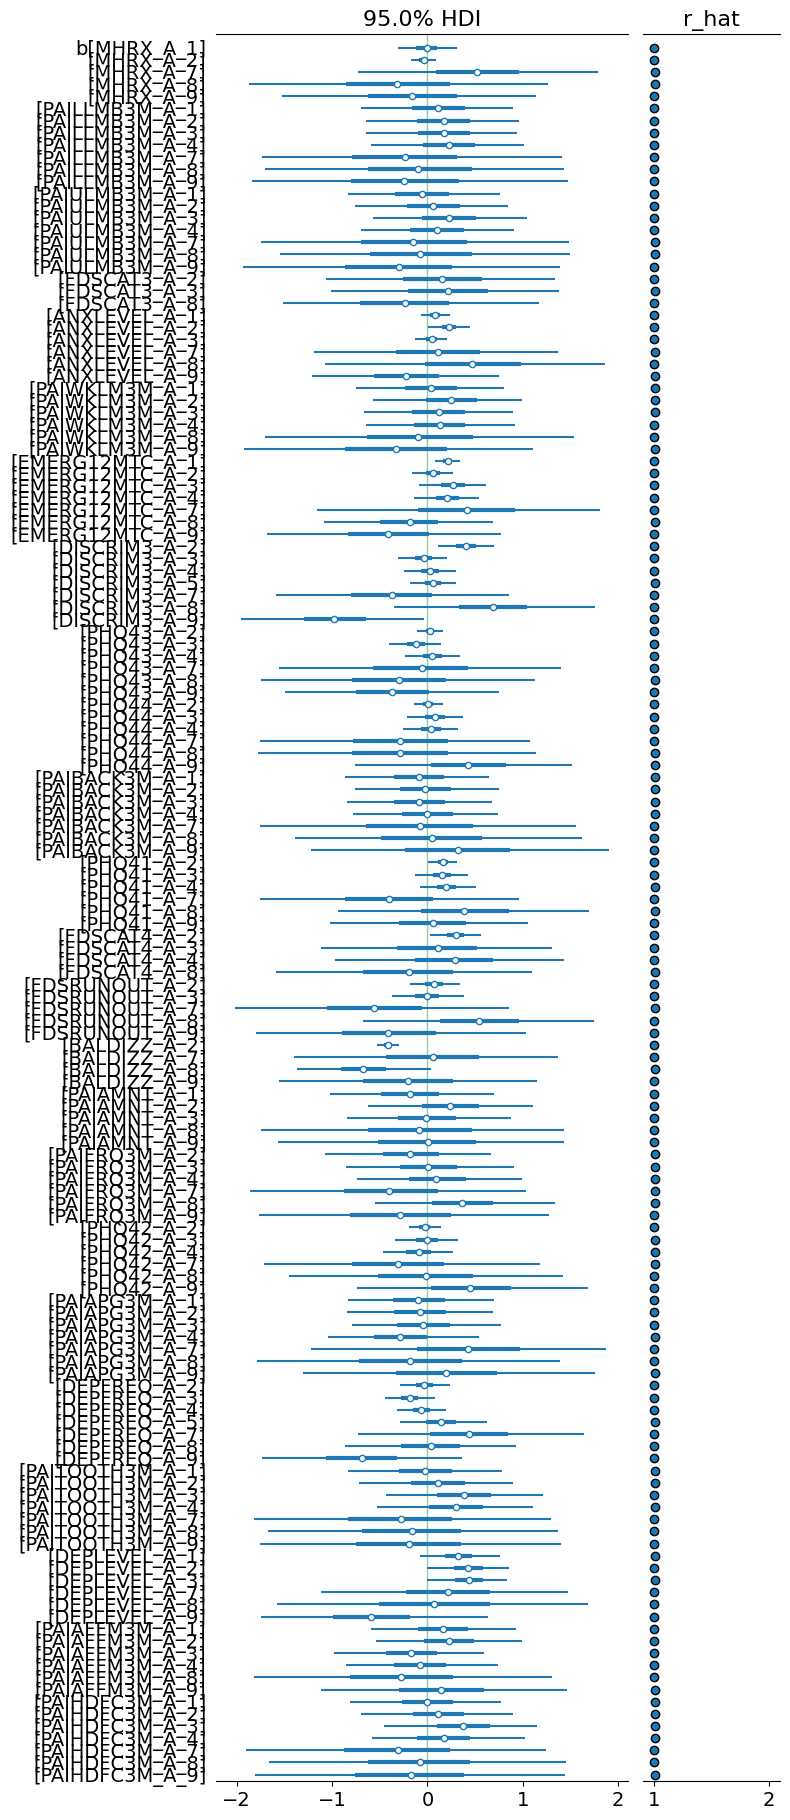

In [132]:
az.plot_forest(idata_gen, var_names=["b"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0, 0));
plt.tight_layout()

In [133]:
with gen_model:
    pm.set_data({"X": X_test.values, "y": y_test})
    idata_gen.extend(pm.sample_posterior_predictive(idata_gen))

Sampling: [obs]


Output()

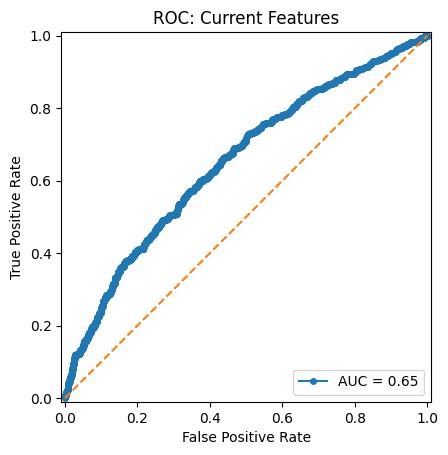

In [134]:
# ROC for general model
p_test_pred = idata_gen.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()

plot_roc(y_test, p_test_pred, title="ROC: Current Features")

# AFTER SECOND BAYES

In [3]:
from preprocessing import preprocess_after_second_bayes

In [4]:
X_train, X_test, y_train, y_test = preprocess_after_second_bayes(df_full)

/Users/katherinehunter/Github/bayesian-lcovid/preprocessing.py:291: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bayes_df['HYSTEV2_A'].loc[bayes_df['HYSTEV2_A'].isna()] = 2
/Users/katherinehunter/Github/bayesian-lcovid/preprocessing.py:291:

In [5]:
X_train

BALDIZZ_A_2  BALDIZZ_A_7  BALDIZZ_A_8  BALDIZZ_A_9  PAIHDFC3M_A_1  \
4006           0.0          0.0          0.0          0.0            0.0   
7701           1.0          0.0          0.0          0.0            1.0   
24142          0.0          0.0          0.0          0.0            0.0   
17695          0.0          0.0          0.0          0.0            0.0   
11763          1.0          0.0          0.0          0.0            1.0   
...            ...          ...          ...          ...            ...   
4515           1.0          0.0          0.0          0.0            0.0   
16749          1.0          0.0          0.0          0.0            0.0   
6687           0.0          0.0          0.0          0.0            0.0   
4685           1.0          0.0          0.0          0.0            0.0   
4540           0.0          0.0          0.0          0.0            0.0   

       PAIHDFC3M_A_2  PAIHDFC3M_A_3  PAIHDFC3M_A_4  PAIHDFC3M_A_7  \
4006             0.0            0.0            1.0            0.0   
7701             0.0            0.0            0.0            0.0   
24142            1.0            0.0            0.0            0.0   
17695            1.0            0.0            0.0            0.0   
11763            0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
4515             0.0            0.0            0.0            0.0   
16749            0.0            0.0            0.0            0.0   
6687             1.0            0.0            0.0            0.0   
4685             0.0            0.0            0.0            0.0   
4540             0.0            1.0            0.0            0.0   

       PAIHDFC3M_A_8  ...  SHTCVD19NM1_A_3  SHTCVD19NM1_A_4  SHTCVD19NM1_A_5  \
4006             0.0  ...              0.0              0.0              1.0   
7701             0.0  ...              0.0              0.0              0.0   
24142            0.0  ...              0.0              0.0              0.0   
17695            0.0  ...              1.0              0.0              0.0   
11763            0.0  ...              0.0              1.0              0.0   
...              ...  ...              ...              ...              ...   
4515             0.0  ...              1.0              0.0              0.0   
16749            0.0  ...              0.0              1.0              0.0   
6687             0.0  ...              0.0              0.0              1.0   
4685             0.0  ...              0.0              0.0              0.0   
4540             0.0  ...              0.0              0.0              0.0   

       SHTCVD19NM1_A_6  SHTCVD19NM1_A_7  SHTCVD19NM1_A_8  SHTCVD19NM1_A_9  \
4006               0.0              0.0              0.0              0.0   
7701               0.0              0.0              0.0              0.0   
24142              0.0              0.0              0.0              0.0   
17695              0.0              0.0              0.0              0.0   
11763              0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
4515               0.0              0.0              0.0              0.0   
16749              0.0              0.0              0.0              0.0   
6687               0.0              0.0              0.0              0.0   
4685               0.0              0.0              0.0              0.0   
4540               0.0              0.0              0.0              0.0   

       CFSEV_A_2  CFSEV_A_7  CFSEV_A_9  
4006         1.0        0.0        0.0  
7701         1.0        0.0        0.0  
24142        1.0        0.0        0.0  
17695        1.0        0.0        0.0  
11763        1.0        0.0        0.0  
...          ...        ...        ...  
4515         1.0        0.0        0.0  
16749        1.0        0.0        0.0  
6687      

In [6]:
coords = {"coeffs":X_train.columns}

with pm.Model(coords=coords) as bayes2_model:
    # data containers
    X = pm.Data("X", X_train.values)
    y = pm.Data("y", y_train)
    # priors
    b0 = pm.Normal("b0", 0, 100) # intercept: no shrinkage
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    # linear model
    mu = b0 + pm.math.dot(X, b)
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)
bayes2_model

 b0 ~ Normal(0, 100)
  b ~ Normal(0, 1)
  p ~ Deterministic(f(b, b0))
obs ~ Bernoulli(p)

In [7]:
with bayes2_model:
    idata_bayes2 = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [23]:
summary1 = az.summary(idata_lit, var_names="b")
summary1

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
b[BALDIZZ_A_2]     -0.541  0.059  -0.654   -0.434      0.001    0.000   
b[BALDIZZ_A_7]      0.001  0.805  -1.483    1.479      0.009    0.006   
b[BALDIZZ_A_8]     -0.066  0.571  -1.115    1.039      0.006    0.005   
b[BALDIZZ_A_9]     -0.233  0.786  -1.657    1.310      0.009    0.006   
b[PAIHDFC3M_A_1]    0.122  0.351  -0.553    0.767      0.004    0.003   
b[PAIHDFC3M_A_2]    0.272  0.352  -0.423    0.898      0.004    0.003   
b[PAIHDFC3M_A_3]    0.593  0.357  -0.090    1.257      0.004    0.003   
b[PAIHDFC3M_A_4]    0.350  0.356  -0.349    0.985      0.004    0.003   
b[PAIHDFC3M_A_7]   -0.493  0.875  -2.184    1.124      0.010    0.007   
b[PAIHDFC3M_A_8]   -0.365  0.704  -1.688    0.956      0.008    0.006   
b[PAIHDFC3M_A_9]   -0.136  0.944  -1.809    1.706      0.011    0.007   
b[HRLOUDJOB_A_2]   -0.378  0.060  -0.490   -0.263      0.001    0.000   
b[HRLOUDJOB_A_7]    0.246  0.808  -1.258    1.735      0.009    0.006   
b[HRLOUDJOB_A_8]   -0.658  0.561  -1.766    0.360      0.006    0.004   
b[HRLOUDJOB_A_9]   -0.001  0.677  -1.221    1.313      0.008    0.005   
b[ASEV_A_2]        -0.357  0.063  -0.481   -0.242      0.001    0.001   
b[ASEV_A_7]        -0.535  0.870  -2.194    1.095      0.010    0.007   
b[ASEV_A_9]         0.132  0.683  -1.118    1.419      0.008    0.006   
b[SEX_A_2]          0.301  0.060   0.189    0.416      0.001    0.000   
b[SEX_A_7]          0.750  0.929  -0.945    2.512      0.010    0.007   
b[SEX_A_9]          0.008  1.009  -1.877    1.900      0.011    0.008   
b[HYSTEV2_A_2]     -0.444  0.076  -0.596   -0.307      0.001    0.001   
b[HYSTEV2_A_7]     -0.516  0.840  -2.112    1.028      0.010    0.007   
b[HYSTEV2_A_8]     -0.092  0.326  -0.708    0.511      0.004    0.003   
b[HYSTEV2_A_9]     -0.769  0.815  -2.290    0.765      0.009    0.006   
b[PAIAMNT_A_1]     -0.125  0.351  -0.810    0.510      0.004    0.003   
b[PAIAMNT_A_2]      0.558  0.352  -0.093    1.227      0.004    0.003   
b[PAIAMNT_A_3]      0.212  0.349  -0.448    0.854      0.004    0.003   
b[PAIAMNT_A_8]     -0.158  0.947  -2.023    1.542      0.011    0.008   
b[PAIAMNT_A_9]     -0.126  0.775  -1.594    1.304      0.009    0.006   
b[SHTCVD19NM1_A_1]  0.062  0.119  -0.171    0.275      0.001    0.001   
b[SHTCVD19NM1_A_2] -0.054  0.074  -0.197    0.081      0.001    0.001   
b[SHTCVD19NM1_A_3] -0.244  0.075  -0.382   -0.102      0.001    0.001   
b[SHTCVD19NM1_A_4] -0.264  0.088  -0.431   -0.101      0.001    0.001   
b[SHTCVD19NM1_A_5] -0.559  0.139  -0.832   -0.310      0.002    0.001   
b[SHTCVD19NM1_A_6] -0.462  0.274  -0.976    0.037      0.003    0.002   
b[SHTCVD19NM1_A_7]  0.627  0.736  -0.733    2.021      0.008    0.006   
b[SHTCVD19NM1_A_8] -0.110  0.939  -1.886    1.637      0.011    0.008   
b[SHTCVD19NM1_A_9] -0.898  0.620  -2.027    0.293      0.007    0.005   
b[CFSEV_A_2]       -0.698  0.154  -0.984   -0.408      0.002    0.001   
b[CFSEV_A_7]       -0.673  0.831  -2.273    0.820      0.009    0.007   
b[CFSEV_A_9]       -0.393  0.631  -1.611    0.719      0.007    0.005   

                    ess_bulk  ess_tail  r_hat  
b[BALDIZZ_A_2]        6998.0    7127.0    1.0  
b[BALDIZZ_A_7]        7835.0    7728.0    1.0  
b[BALDIZZ_A_8]        7999.0    7443.0    1.0  
b[BALDIZZ_A_9]        7966.0    8142.0    1.0  
b[PAIHDFC3M_A_1]      7760.0    7770.0    1.0  
b[PAIHDFC3M_A_2]      7781.0    7601.0    1.0  
b[PAIHDFC3M_A_3]      7746.0    7646.0    1.0  
b[PAIHDFC3M_A_4]      7821.0    7849.0    1.0  
b[PAIHDFC3M_A_7]      7843.0    7493.0    1.0  
b[PAIHDFC3M_A_8]      8164.0    8053.0    1.0  
b[PAIHDFC3M_A_9]      8039.0    7809.0    1.0  
b[HRLOUDJOB_A_2]      7483.0    7282.0    1.0  
b[HRLOUDJOB_A_7]      7837.0    7206.0    1.0  
b[HRLOUDJOB_A_8]      7903.0    7801.0    1.0  
b[HRLOUDJOB_A_9]      7625.0    7369.0    1.0  
b[ASEV_A_2]           7872.0    7799.0    1.0  
b[ASEV_A_7]           7724.0    7572.0    1.0  
b[ASEV_A_9]      

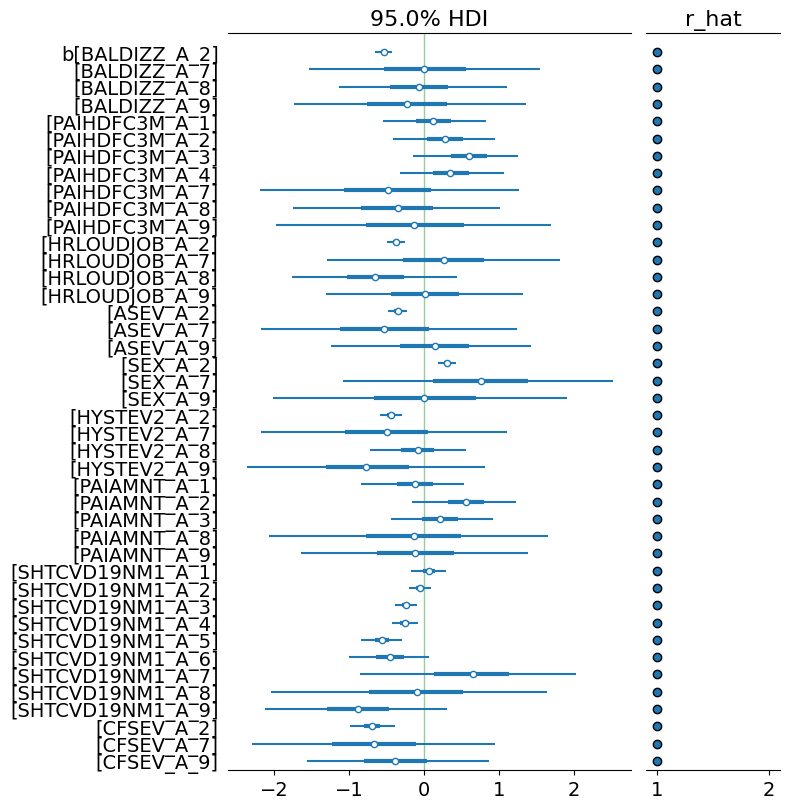

In [9]:
az.plot_forest(idata_bayes2, var_names=["b"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0, 0));
plt.tight_layout()

In [10]:
with bayes2_model:
    pm.set_data({"X": X_test.values, "y": y_test})
    idata_bayes2.extend(pm.sample_posterior_predictive(idata_bayes2))

Sampling: [obs]


Output()

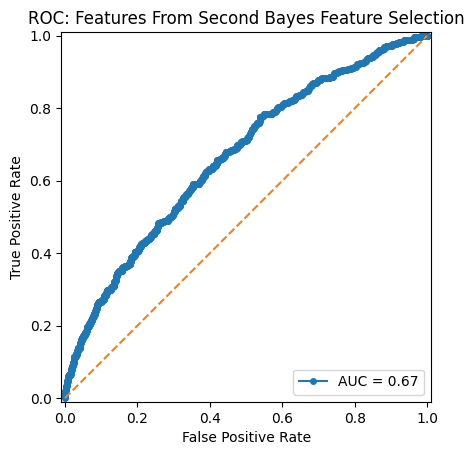

In [13]:
# ROC for Bayes2 model
p_test_pred_b2 = idata_lit.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred_b2 = (p_test_pred_b2 >= 0.5).astype("int").to_numpy()

plot_roc(y_test, p_test_pred_b2, title="ROC: Features From Second Bayes Feature Selection")

# BAYES 2 W HIERARCHICAL

In [15]:
coords = {"coeffs":X_train.columns}


with pm.Model(coords=coords) as hier_bayes2_model:
    # data containers
    X = pm.Data("X", X_train.values)
    y = pm.Data("y", y_train)

    mu = 0

    # No shrinkage on intercept
    b0 = pm.Normal("beta0", 0, 100)

    mu += b0 # add intercept

    # GROUP UNKNOWN ENTRIES
    unknowns_cols = X_train.filter(regex='_9$|_7$|_8$').columns
    unknowns_idx = [i for i, col in enumerate(X_train.columns) if col in unknowns_cols]
    unknowns_mu = pm.Normal(f"unknowns_mu", mu=0, sigma=1)
    unknowns_sigma = pm.HalfNormal(f"unknowns_sigma", sigma=1)
    for i, unknown in zip(unknowns_idx, unknowns_cols):
        b = pm.Normal(f"b_{unknown}", mu=unknowns_mu, sigma=unknowns_sigma)
        mu += X[:, i] * b

    other_cols = X_train.columns[~X_train.columns.isin(unknowns_cols)]
    other_idx = [i for i, col in enumerate(X_train.columns) if col in other_cols]

    for i, single in zip(other_idx, other_cols):
        b = pm.Normal(f"b_{single}", mu=0, sigma=1)
        mu += X[:, i] * b
        
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)
hier_bayes2_model

            beta0 ~ Normal(0, 100)
      unknowns_mu ~ Normal(0, 1)
   unknowns_sigma ~ HalfNormal(0, 1)
    b_BALDIZZ_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
    b_BALDIZZ_A_8 ~ Normal(unknowns_mu, unknowns_sigma)
    b_BALDIZZ_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
  b_PAIHDFC3M_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
  b_PAIHDFC3M_A_8 ~ Normal(unknowns_mu, unknowns_sigma)
  b_PAIHDFC3M_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
  b_HRLOUDJOB_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
  b_HRLOUDJOB_A_8 ~ Normal(unknowns_mu, unknowns_sigma)
  b_HRLOUDJOB_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
       b_ASEV_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
       b_ASEV_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
        b_SEX_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
        b_SEX_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
    b_HYSTEV2_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
    b_HYSTEV2_A_8 ~ Normal(unknowns_mu, unknowns_sigma)
    b_HYSTEV2_A_9 ~ Normal(unknowns_mu, unknowns_sigma)

In [16]:
with hier_bayes2_model:
    idata_hier_bayes2 = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [24]:
summary2 = az.summary(idata_hier_bayes2, var_names='b_', filter_vars="like")
summary2

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
b_BALDIZZ_A_7     -0.292  0.412  -1.063    0.520      0.005    0.013   
b_BALDIZZ_A_8     -0.282  0.278  -0.802    0.260      0.003    0.002   
b_BALDIZZ_A_9     -0.352  0.402  -1.143    0.383      0.005    0.016   
b_PAIHDFC3M_A_7   -0.413  0.421  -1.266    0.357      0.006    0.026   
b_PAIHDFC3M_A_8   -0.378  0.391  -1.168    0.351      0.004    0.017   
b_PAIHDFC3M_A_9   -0.360  0.432  -1.202    0.462      0.005    0.019   
b_HRLOUDJOB_A_7   -0.252  0.414  -1.057    0.536      0.005    0.009   
b_HRLOUDJOB_A_8   -0.413  0.273  -0.952    0.075      0.003    0.015   
b_HRLOUDJOB_A_9   -0.283  0.390  -1.029    0.474      0.004    0.012   
b_ASEV_A_7        -0.434  0.407  -1.185    0.371      0.005    0.020   
b_ASEV_A_9        -0.256  0.397  -0.993    0.526      0.004    0.005   
b_SEX_A_7         -0.197  0.435  -1.003    0.654      0.005    0.011   
b_SEX_A_9         -0.340  0.434  -1.199    0.487      0.005    0.024   
b_HYSTEV2_A_7     -0.418  0.420  -1.236    0.383      0.005    0.027   
b_HYSTEV2_A_8     -0.216  0.259  -0.702    0.273      0.003    0.002   
b_HYSTEV2_A_9     -0.458  0.404  -1.250    0.295      0.006    0.026   
b_PAIAMNT_A_8     -0.351  0.425  -1.185    0.466      0.005    0.018   
b_PAIAMNT_A_9     -0.325  0.398  -1.070    0.463      0.004    0.012   
b_SHTCVD19NM1_A_7 -0.142  0.425  -0.943    0.692      0.027    0.019   
b_SHTCVD19NM1_A_8 -0.352  0.432  -1.178    0.477      0.005    0.024   
b_SHTCVD19NM1_A_9 -0.537  0.378  -1.292    0.137      0.028    0.027   
b_CFSEV_A_7       -0.458  0.407  -1.262    0.308      0.006    0.026   
b_CFSEV_A_9       -0.373  0.374  -1.095    0.345      0.004    0.020   
b_BALDIZZ_A_2     -0.543  0.060  -0.657   -0.431      0.001    0.000   
b_PAIHDFC3M_A_1    0.120  0.337  -0.517    0.749      0.004    0.003   
b_PAIHDFC3M_A_2    0.273  0.338  -0.346    0.927      0.004    0.003   
b_PAIHDFC3M_A_3    0.591  0.344  -0.046    1.244      0.004    0.003   
b_PAIHDFC3M_A_4    0.350  0.343  -0.312    0.977      0.004    0.003   
b_HRLOUDJOB_A_2   -0.380  0.060  -0.498   -0.273      0.001    0.000   
b_ASEV_A_2        -0.358  0.063  -0.478   -0.240      0.001    0.001   
b_SEX_A_2          0.301  0.060   0.187    0.413      0.001    0.000   
b_HYSTEV2_A_2     -0.449  0.076  -0.591   -0.308      0.001    0.001   
b_PAIAMNT_A_1     -0.128  0.338  -0.772    0.489      0.004    0.003   
b_PAIAMNT_A_2      0.555  0.340  -0.089    1.181      0.004    0.003   
b_PAIAMNT_A_3      0.209  0.338  -0.446    0.821      0.004    0.003   
b_SHTCVD19NM1_A_1  0.059  0.119  -0.163    0.278      0.001    0.001   
b_SHTCVD19NM1_A_2 -0.053  0.074  -0.196    0.085      0.001    0.001   
b_SHTCVD19NM1_A_3 -0.242  0.076  -0.386   -0.103      0.001    0.001   
b_SHTCVD19NM1_A_4 -0.267  0.088  -0.438   -0.107      0.001    0.001   
b_SHTCVD19NM1_A_5 -0.561  0.139  -0.830   -0.307      0.002    0.001   
b_SHTCVD19NM1_A_6 -0.467  0.280  -0.978    0.064      0.003    0.002   
b_CFSEV_A_2       -0.696  0.152  -0.975   -0.409      0.002    0.001   

                   ess_bulk  ess_tail  r_hat  
b_BALDIZZ_A_7        7690.0    2370.0   1.05  
b_BALDIZZ_A_8        7894.0    3239.0   1.04  
b_BALDIZZ_A_9        7748.0    2608.0   1.04  
b_PAIHDFC3M_A_7      5483.0     707.0   1.04  
b_PAIHDFC3M_A_8      8030.0    5046.0   1.03  
b_PAIHDFC3M_A_9      7422.0    5372.0   1.04  
b_HRLOUDJOB_A_7      7654.0    1674.0   1.04  
b_HRLOUDJOB_A_8      6899.0    1955.0   1.04  
b_HRLOUDJOB_A_9      7863.0    5075.0   1.04  
b_ASEV_A_7           7255.0    2928.0   1.04  
b_ASEV_A_9           7881.0    6416.0   1.04  
b_SEX_A_7            6544.0     973.0   1.04  
b_SEX_A_9            7910.0    2677.0   1.05  
b_HYSTEV2_A_7        7101.0    3765.0   1.04  
b_HYSTEV2_A_8        6142.0    5367.0   1.02  
b_HYSTEV2_A_9        5277.0    6921.0   1.03  
b_PAIAMNT_A_8        7460.0    1453.0   1.05  
b_PAIAMNT_A_9        8302.0    5500.0   1.03  
b_SHTCVD19NM1_A_7     280.0   

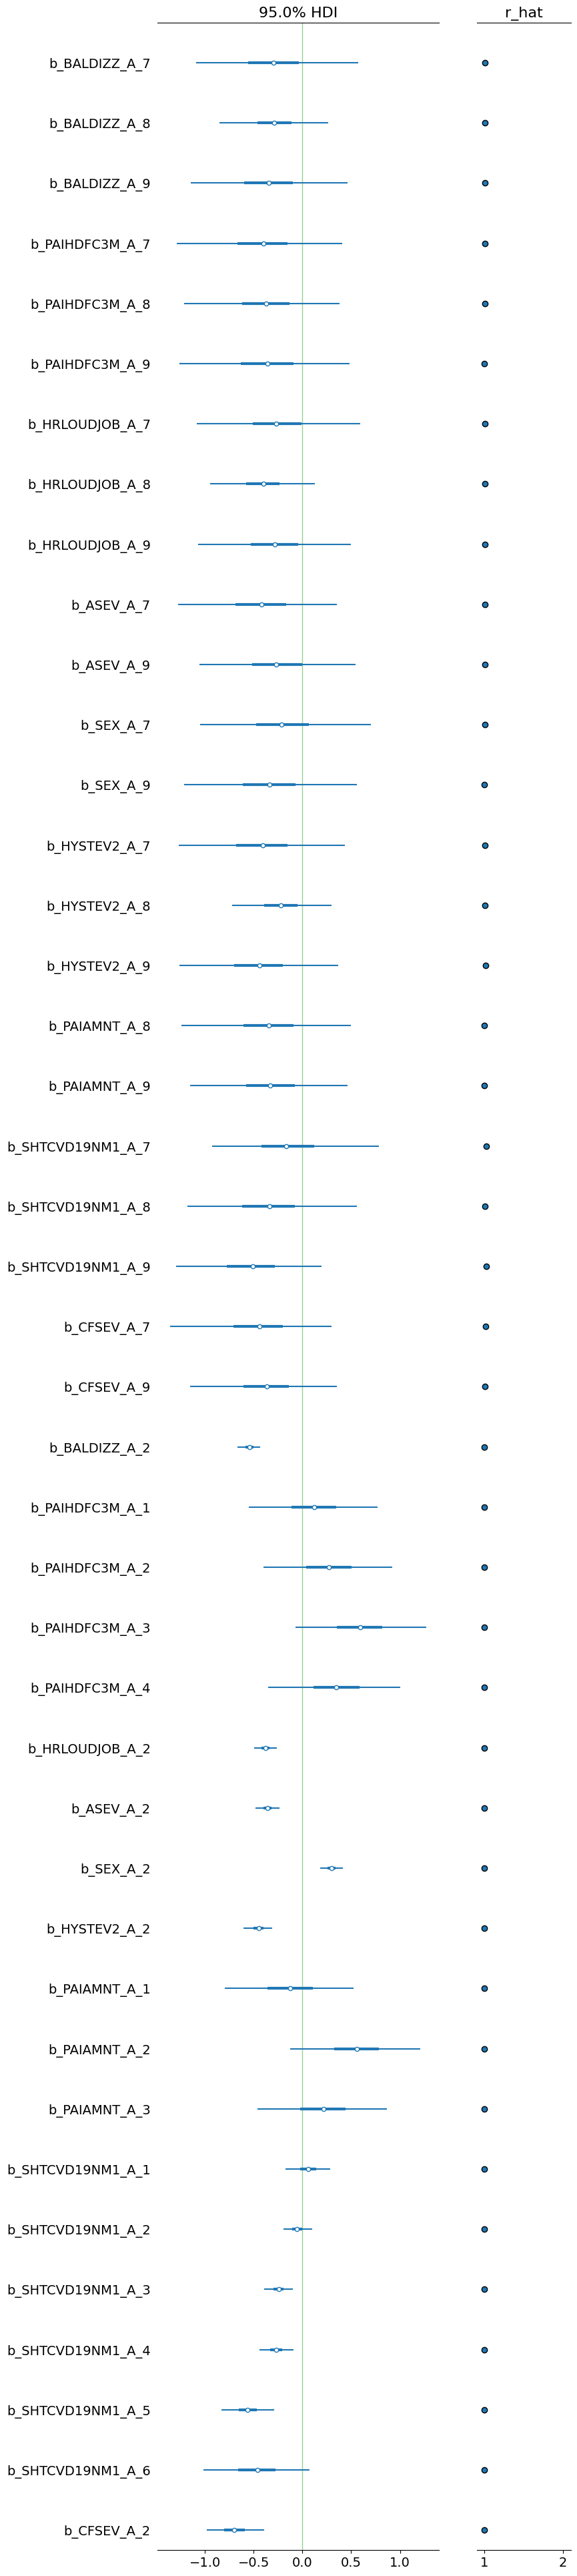

In [20]:
az.plot_forest(idata_hier_bayes2, var_names='b_', filter_vars="like", combined=True, hdi_prob=0.95, r_hat=True, rope=(0, 0));

In [21]:
with hier_bayes2_model:
    pm.set_data({"X": X_test.values, "y": y_test})
    idata_hier_bayes2.extend(pm.sample_posterior_predictive(idata_hier_bayes2))

Sampling: [obs]


Output()

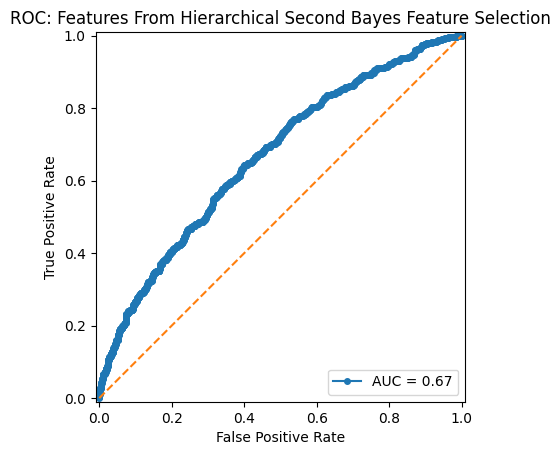

In [22]:
# ROC for Bayes2 hierarchical model
p_test_pred_hb2 = idata_hier_bayes2.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred_hb2 = (p_test_pred_hb2 >= 0.5).astype("int").to_numpy()

plot_roc(y_test, p_test_pred_hb2, title="ROC: Features From Hierarchical Second Bayes Feature Selection")

In [78]:
len(idata_lit.posterior.coeffs.values)

42

In [69]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

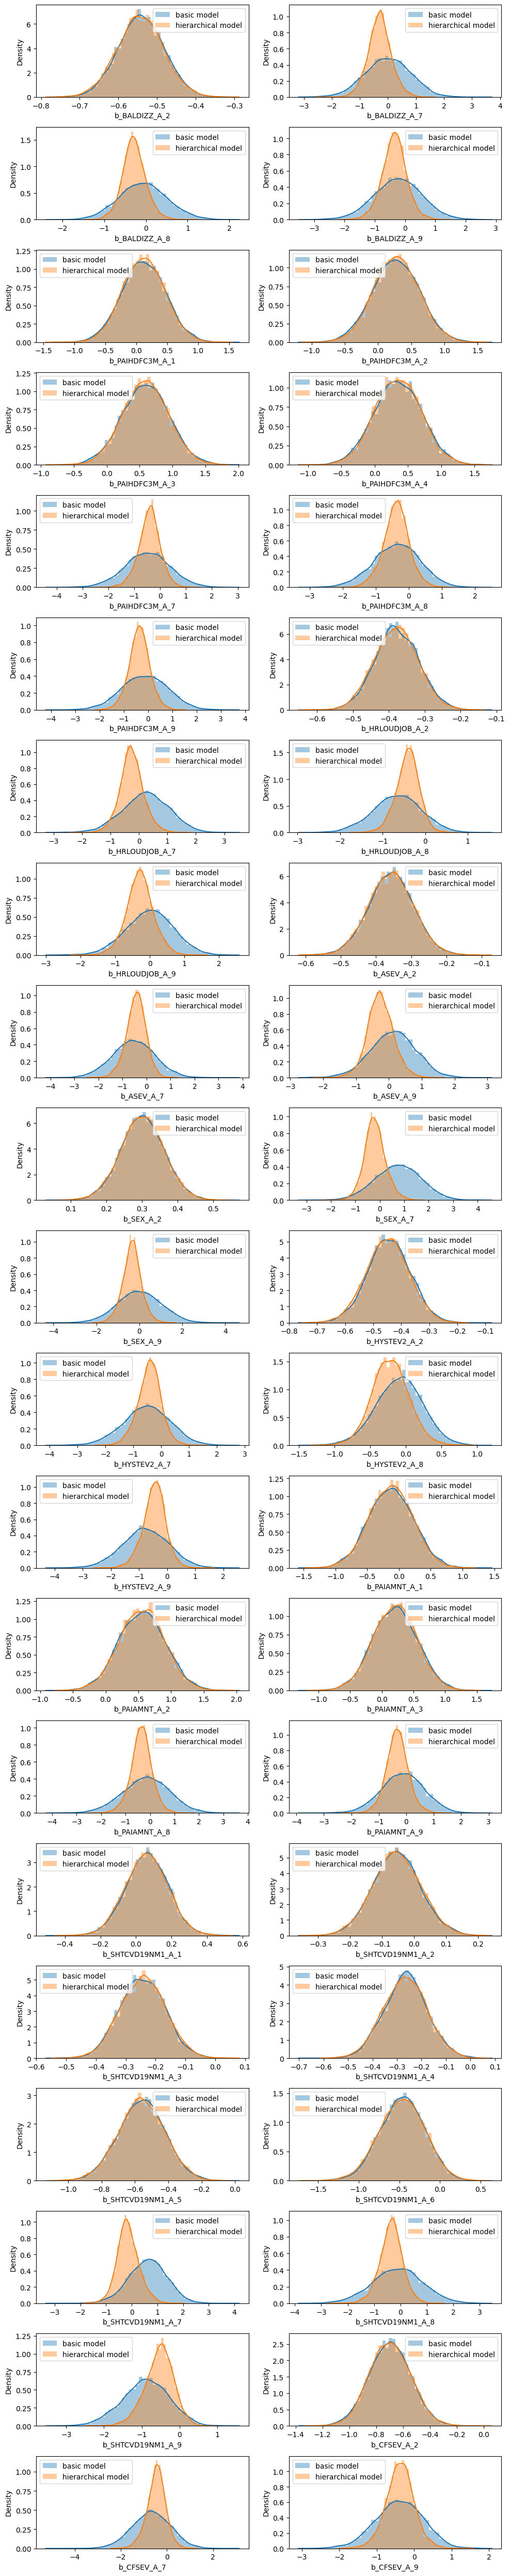

In [81]:
feat_name = 'SEX_A_9'

_, axs=plt.subplots(21,2,figsize=(10,50))

for ax, feat_name in zip(axs.flatten(), idata_lit.posterior.coeffs.values):
    idx = np.where((idata_lit.posterior['b'].coeffs == feat_name).values)[0].item()
    sns.distplot(idata_lit.posterior['b'][:,:,idx], ax=ax, label='basic model')
    sns.distplot(idata_hier_bayes2.posterior[f'b_{feat_name}'], ax=ax, label='hierarchical model')
    ax.legend();
plt.tight_layout()

In [31]:
np.abs(summary1['mean']).sort_values(ascending=False)
np.abs(summary2['mean']).sort_values(ascending=False)

b_CFSEV_A_2          0.696
b_PAIHDFC3M_A_3      0.591
b_SHTCVD19NM1_A_5    0.561
b_PAIAMNT_A_2        0.555
b_BALDIZZ_A_2        0.543
b_SHTCVD19NM1_A_9    0.537
b_SHTCVD19NM1_A_6    0.467
b_HYSTEV2_A_9        0.458
b_CFSEV_A_7          0.458
b_HYSTEV2_A_2        0.449
b_ASEV_A_7           0.434
b_HYSTEV2_A_7        0.418
b_PAIHDFC3M_A_7      0.413
b_HRLOUDJOB_A_8      0.413
b_HRLOUDJOB_A_2      0.380
b_PAIHDFC3M_A_8      0.378
b_CFSEV_A_9          0.373
b_PAIHDFC3M_A_9      0.360
b_ASEV_A_2           0.358
b_BALDIZZ_A_9        0.352
b_SHTCVD19NM1_A_8    0.352
b_PAIAMNT_A_8        0.351
b_PAIHDFC3M_A_4      0.350
b_SEX_A_9            0.340
b_PAIAMNT_A_9        0.325
b_SEX_A_2            0.301
b_BALDIZZ_A_7        0.292
b_HRLOUDJOB_A_9      0.283
b_BALDIZZ_A_8        0.282
b_PAIHDFC3M_A_2      0.273
b_SHTCVD19NM1_A_4    0.267
b_ASEV_A_9           0.256
b_HRLOUDJOB_A_7      0.252
b_SHTCVD19NM1_A_3    0.242
b_HYSTEV2_A_8        0.216
b_PAIAMNT_A_3        0.209
b_SEX_A_7            0.197
b

# CHI FEATURE SELECTION

In [3]:
chi_feats = ['SEX_A', 'URBRRL', 'MARITAL_A', 
                   'ANXEV_A', 'SHTCVD191_A', 'HISPALLP_A', 
                   'DEPEV_A', 'SMKCIGST_A', 'RATCAT_A', 
                   'MEDRXTRT_A', 'EDUCP_A', 'ARTHEV_A']
df_full.loc[:, chi_feats].isna().sum()

SEX_A          0
URBRRL         0
MARITAL_A      0
ANXEV_A        0
SHTCVD191_A    0
HISPALLP_A     0
DEPEV_A        0
SMKCIGST_A     0
RATCAT_A       0
MEDRXTRT_A     0
EDUCP_A        0
ARTHEV_A       0
dtype: int64

In [60]:
## PREPROCESSING CHI FEATURES
def preprocess_chi_features(df_full):
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    
    chi_feats = ['SEX_A', 'URBRRL', 'MARITAL_A', 
                   'ANXEV_A', 'SHTCVD191_A', 'HISPALLP_A', 
                   'DEPEV_A', 'SMKCIGST_A', 'RATCAT_A', 
                   'MEDRXTRT_A', 'EDUCP_A', 'ARTHEV_A']
    df_chi = df_full[chi_feats]
    df_chi[y_name] = df_full[y_name]
    df_chi = df_chi.dropna(subset=y_name)
    df_chi = df_chi[df_chi[y_name] != 9]

    # edit EDUCP_A
    df_chi['EDUCP_A'][df_chi['EDUCP_A'] > 10] = 0
    
    encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
    scaler = StandardScaler().set_output(transform="pandas")
    
    X = df_chi.drop(columns=y_name)
    
    # define continuous and categorical features
    continuous = ['RATCAT_A', 'EDUCP_A']
    categorical = X.columns[~X.columns.isin(continuous)]
    
    # scale and encode
    cont_df =  scaler.fit_transform(X.loc[:, continuous])
    cat_df = encoder.fit_transform(X.loc[:,categorical])
    
    processed_df = pd.concat((cont_df, cat_df), axis=1)
    ## END PREPROCESSING
    
    X = processed_df.copy()
    y = df_chi.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values
    
    # train test spchi
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)
    return X_train, X_test, y_train, y_test, scaler, encoder

In [61]:
X_train, X_test, y_train, y_test, scaler, encoder = preprocess_chi_features(df_full)

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_23262/866691815.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi[y_name] = df_full[y_name]
/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_23262/866691815.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = va

In [20]:
unknowns_cols = X_train.filter(regex='_9$|_7$|_8$').columns
other_cols = X_train.columns[~X_train.columns.isin(unknowns_cols)]
urban_cols = X_train.filter(regex='URBRRL').columns
[i for i, col in enumerate(X_train.columns) if col in unknowns_cols]
[i for i, col in enumerate(X_train.columns) if col in other_cols]

[0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 13,
 16,
 20,
 21,
 22,
 23,
 24,
 26,
 29,
 30,
 31,
 32,
 34,
 37]

In [21]:
coords = {"coeffs":X_train.columns}

with pm.Model(coords=coords) as hier_chi_model:
    # data containers
    X = pm.Data("X", X_train.values)
    y = pm.Data("y", y_train)

    mu = 0

    # No shrinkage on intercept
    b0 = pm.Normal("beta0", 0, 100)

    mu += b0 # add intercept

    # GROUP UNKNOWN ENTRIES
    unknowns_cols = X_train.filter(regex='_9$|_7$|_8$').columns
    unknowns_idx = [i for i, col in enumerate(X_train.columns) if col in unknowns_cols]
    unknowns_mu = pm.Normal(f"unknowns_mu", mu=0, sigma=1)
    unknowns_sigma = pm.HalfNormal(f"unknowns_sigma", sigma=1)
    for i, unknown in zip(unknowns_idx, unknowns_cols):
        b = pm.Normal(f"b_{unknown}", mu=unknowns_mu, sigma=unknowns_sigma)
        # mu += pm.math.dot(X_train.loc[:, unknown].values, b)
        mu += X[:, i] * b

    # GROUP URBAN/RURAL ENTRIES
    urban_cols = X_train.filter(regex='URBRRL').columns
    urban_idx = [i for i, col in enumerate(X_train.columns) if col in urban_cols]
    urban_mu = pm.Normal(f"urban_mu", mu=0, sigma=1)
    urban_sigma = pm.HalfNormal(f"urban_sigma", sigma=1)
    for i, urban in zip(urban_idx,urban_cols):
        b = pm.Normal(f"b_{urban}", mu=urban_mu, sigma=urban_sigma)
        # mu += pm.math.dot(X_train.loc[:, urban].values, b)
        mu += X[:, i] * b

    other_cols = X_train.columns[~X_train.columns.isin(np.hstack((unknowns_cols,urban_cols)))]
    other_idx = [i for i, col in enumerate(X_train.columns) if col in other_cols]

    for i, single in zip(other_idx, other_cols):
        b = pm.Normal(f"b_{single}", mu=0, sigma=1)
        # mu += pm.math.dot(X_train.loc[:, single].values, b)
        mu += X[:, i] * b
        

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)
hier_chi_model

          beta0 ~ Normal(0, 100)
    unknowns_mu ~ Normal(0, 1)
 unknowns_sigma ~ HalfNormal(0, 1)
      b_SEX_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
      b_SEX_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
  b_MARITAL_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
  b_MARITAL_A_8 ~ Normal(unknowns_mu, unknowns_sigma)
  b_MARITAL_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
    b_ANXEV_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
    b_ANXEV_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
b_SHTCVD191_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
b_SHTCVD191_A_8 ~ Normal(unknowns_mu, unknowns_sigma)
b_SHTCVD191_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
 b_HISPALLP_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
    b_DEPEV_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
    b_DEPEV_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
 b_SMKCIGST_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
 b_MEDRXTRT_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
 b_MEDRXTRT_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
   b_ARTHEV_A_7 ~ Normal(unknowns_mu,

In [22]:
with hier_chi_model:
    idata_hier_chi = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

/Users/katherinehunter/Github/bayesian-lcovid/.venv/lib/python3.11/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (12277), generating only 20 plots
  warnings.warn(


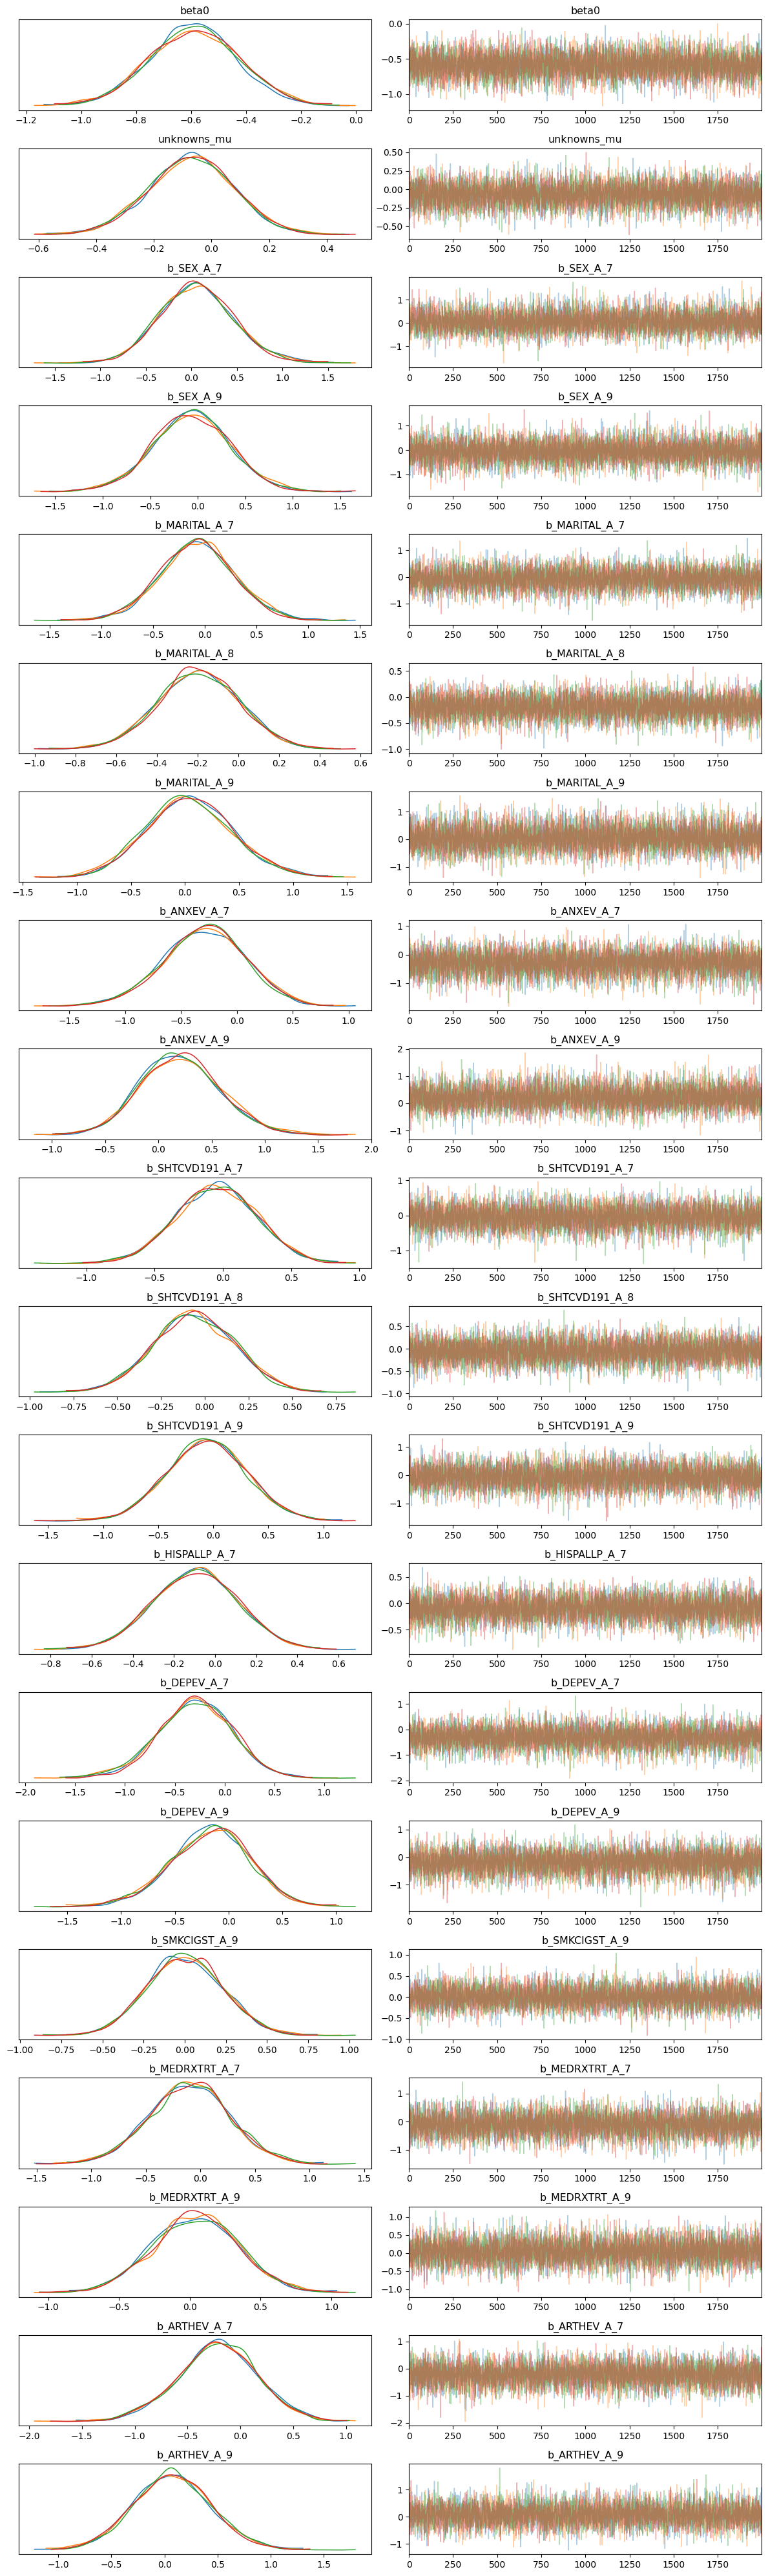

In [29]:
az.plot_trace(idata_hier_chi, compact=False);
plt.tight_layout();

In [24]:
az.summary(idata_hier_chi, var_names='b_', filter_vars="like")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_SEX_A_7        0.060  0.412  -0.702    0.844      0.005    0.003    7818.0   
b_SEX_A_9       -0.064  0.413  -0.842    0.721      0.005    0.003    7899.0   
b_MARITAL_A_7   -0.072  0.361  -0.746    0.620      0.004    0.003    7523.0   
b_MARITAL_A_8   -0.194  0.200  -0.569    0.182      0.002    0.002    7695.0   
b_MARITAL_A_9    0.045  0.406  -0.726    0.814      0.005    0.003    7938.0   
b_ANXEV_A_7     -0.291  0.373  -0.966    0.430      0.004    0.003    7727.0   
b_ANXEV_A_9      0.209  0.379  -0.479    0.930      0.004    0.003    7966.0   
b_SHTCVD191_A_7 -0.050  0.300  -0.586    0.530      0.003    0.002    7801.0   
b_SHTCVD191_A_8 -0.059  0.232  -0.499    0.370      0.003    0.002    7949.0   
b_SHTCVD191_A_9 -0.060  0.361  -0.737    0.614      0.004    0.003    7673.0   
b_HISPALLP_A_7  -0.096  0.205  -0.488    0.275      0.002    0.002    7345.0   
b_DEPEV_A_7     -0.299  0.375  -1.035    0.384      0.004    0.003    7744.0   
b_DEPEV_A_9     -0.175  0.373  -0.895    0.516      0.004    0.003    7531.0   
b_SMKCIGST_A_9   0.002  0.230  -0.421    0.434      0.003    0.002    7827.0   
b_MEDRXTRT_A_7  -0.102  0.370  -0.799    0.606      0.004    0.003    7900.0   
b_MEDRXTRT_A_9   0.041  0.304  -0.507    0.632      0.004    0.003    7352.0   
b_ARTHEV_A_7    -0.218  0.377  -0.989    0.457      0.004    0.003    8076.0   
b_ARTHEV_A_9     0.075  0.368  -0.668    0.723      0.004    0.003    7189.0   
b_URBRRL_2      -0.015  0.073  -0.158    0.118      0.001    0.001    7888.0   
b_URBRRL_3       0.156  0.066   0.031    0.276      0.001    0.001    8081.0   
b_URBRRL_4       0.183  0.080   0.036    0.338      0.001    0.001    7754.0   
b_RATCAT_A      -0.120  0.030  -0.174   -0.065      0.000    0.000    7829.0   
b_EDUCP_A        0.003  0.030  -0.053    0.059      0.000    0.000    7193.0   
b_SEX_A_2        0.320  0.055   0.212    0.418      0.001    0.000    7902.0   
b_MARITAL_A_2   -0.000  0.101  -0.186    0.196      0.001    0.001    7747.0   
b_MARITAL_A_3   -0.001  0.056  -0.103    0.106      0.001    0.000    7982.0   
b_ANXEV_A_2     -0.323  0.072  -0.461   -0.190      0.001    0.001    7303.0   
b_SHTCVD191_A_2  0.179  0.065   0.053    0.299      0.001    0.001    7830.0   
b_HISPALLP_A_2  -0.164  0.074  -0.307   -0.029      0.001    0.001    8122.0   
b_HISPALLP_A_3  -0.210  0.108  -0.409   -0.004      0.001    0.001    7812.0   
b_HISPALLP_A_4  -0.390  0.146  -0.663   -0.121      0.002    0.001    7976.0   
b_HISPALLP_A_5  -0.036  0.265  -0.528    0.470      0.003    0.002    7898.0   
b_HISPALLP_A_6  -0.098  0.271  -0.602    0.413      0.003    0.002    7453.0   
b_DEPEV_A_2     -0.399  0.071  -0.526   -0.265      0.001    0.001    7367.0   
b_SMKCIGST_A_2  -0.053  0.177  -0.371    0.287      0.002    0.001    7840.0   
b_SMKCIGST_A_3  -0.059  0.104  -0.243    0.149      0.001    0.001    7805.0   
b_SMKCIGST_A_4  -0.234  0.099  -0.418   -0.047      0.001    0.001    7682.0   
b_SMKCIGST_A_5  -0.300  0.895  -2.076    1.279      0.010    0.007    7871.0   
b_MEDRXTRT_A_2  -0.300  0.096  -0.482   -0.126      0.001    0.001    7766.0   
b_ARTHEV_A_2    -0.368  0.058  -0.476   -0.261      0.001    0.000    7953.0   

                 ess_tail  r_hat  
b_SEX_A_7          7739.0    1.0  
b_SEX_A_9          7690.0    1.0  
b_MARITAL_A_7      8008.0    1.0  
b_MARITAL_A_8      7599.0    1.0  
b_MARITAL_A_9      7698.0    1.0  
b_ANXEV_A_7        7407.0    1.0  
b_ANXEV_A_9        7642.0    1.0  
b_SHTCVD191_A_7    7854.0    1.0  
b_SHTCVD191_A_8    7309.0    1.0  
b_SHTCVD191_A_9    7649.0    1.0  
b_HISPALLP_A_7     7829.0    1.0  
b_DEPEV_A_7        7846.0    1.0  
b_DEPEV_A_9        7539.0    1.0  
b_SMKCIGST_A_9     7813.0    1.0  
b_MEDRXTRT_A_7     7285.0    1.0  
b_MEDRXTRT_A_9     7415.0    1.0  
b_ARTHEV_A_7       7770.0    1.0  
b_ARTHEV_A_9       7676.0    1.0  
b_URBRRL_2         7547.0    1.0  
b_URBRRL_3         7613.0    1.0  
b_

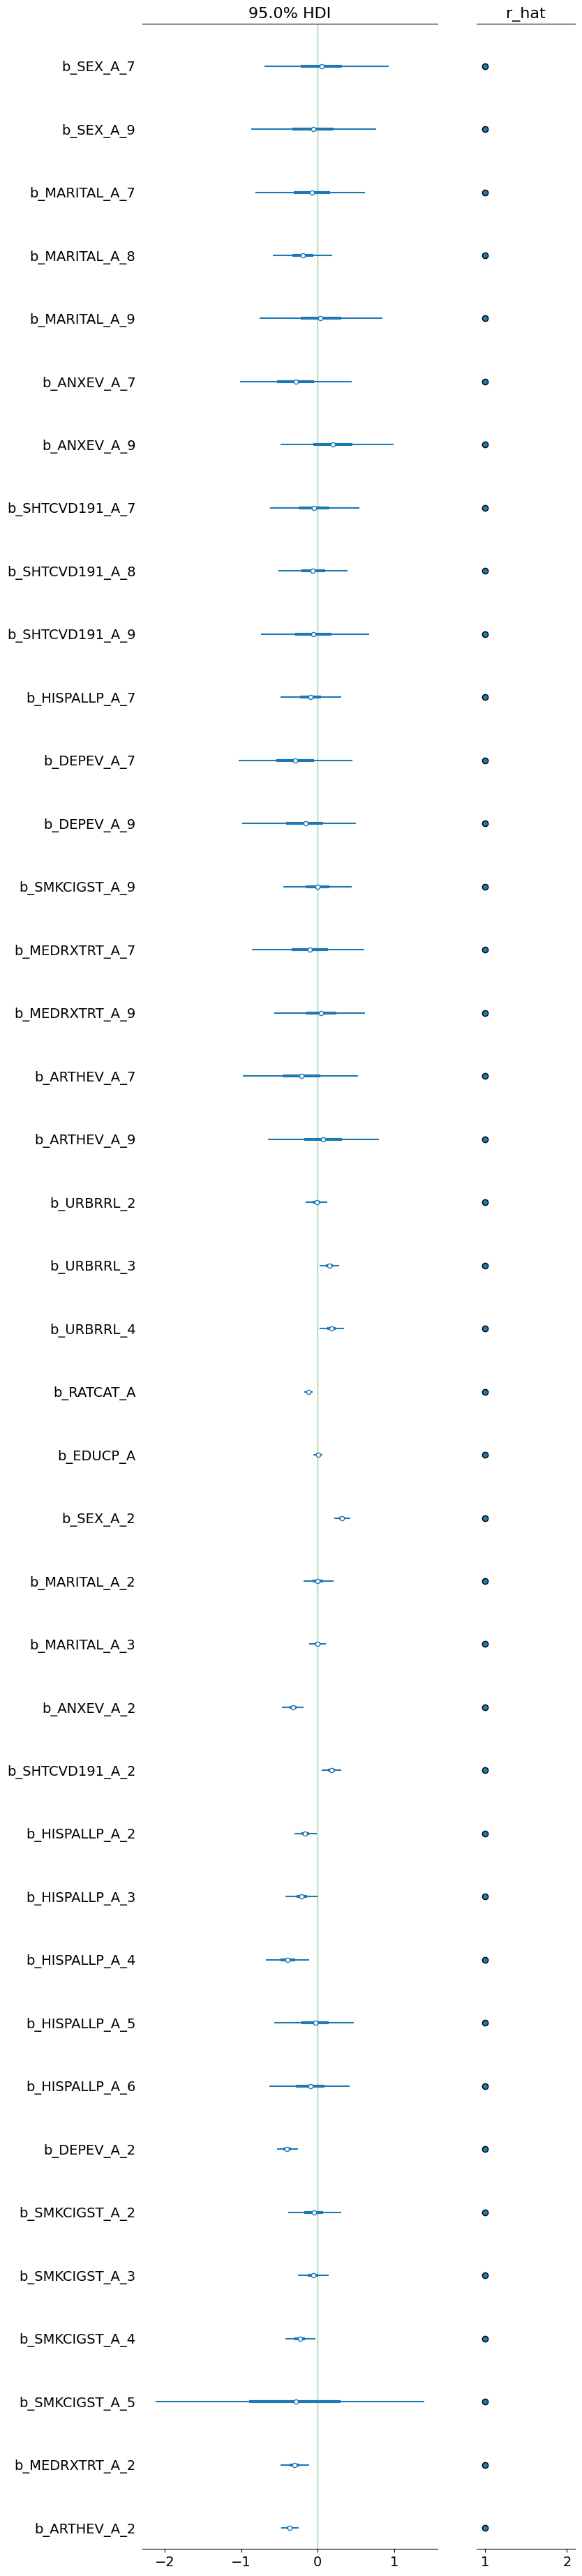

In [25]:
az.plot_forest(idata_hier_chi, var_names='b_', filter_vars="like", combined=True, hdi_prob=0.95, r_hat=True, rope=(0, 0));

In [26]:
def plot_roc(y_true, p_pred, title="ROC"):
    fpr, tpr, thresholds = roc_curve(
        y_true=y_true, y_score=p_pred, pos_label=1, drop_intermediate=False
    )
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots()
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
    x = np.linspace(0,1)
    y = x
    plt.plot(x,y, linestyle='--')
    ax.set(title=title);

def get_preds(trace, y_true):
    p_pred = trace.predictions["obs"].mean(dim=["chain", "draw"])
    y_pred = (p_pred >= 0.5).astype("int").to_numpy()
    print(f"accuracy = {np.mean(y_true==y_pred): 0.3f}")

    return p_pred, y_pred

# p_train_pred, y_train_pred = get_preds(idata_hier_chi, y_train)
# plot_roc(y_train, p_train_pred, title="Simple model ROC")

In [27]:
with hier_chi_model:
    pm.set_data({"X": X_test.values, "y": y_test})
    idata_hier_chi.extend(pm.sample_posterior_predictive(idata_hier_chi))

Sampling: [obs]


Output()

accuracy =  0.843


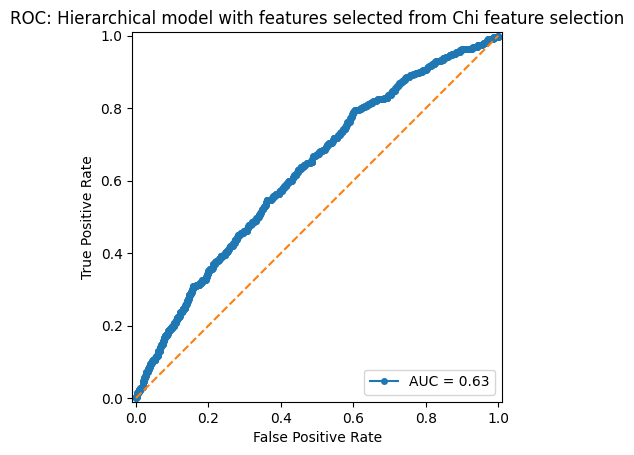

In [28]:
# ROC for Hier Ci model
p_test_pred = idata_hier_chi.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()
print(f"accuracy = {np.mean(y_test==y_test_pred): 0.3f}")
plot_roc(y_test, p_test_pred, title="ROC: Hierarchical model with features selected from Chi feature selection")

In [30]:
idata_hier_chi

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [66]:
cont_cols = ['RATCAT_A', 'EDUCP_A']
unscaled_cont = pd.DataFrame(scaler.inverse_transform(X_train[cont_cols]), columns = cont_cols)
unscaled_cont

RATCAT_A  EDUCP_A
0          14.0      8.0
1           4.0      4.0
2           8.0      7.0
3          12.0      8.0
4          12.0      8.0
...         ...      ...
12227      14.0      7.0
12228      13.0      9.0
12229      10.0      8.0
12230      11.0      8.0
12231       9.0      4.0

[12232 rows x 2 columns]

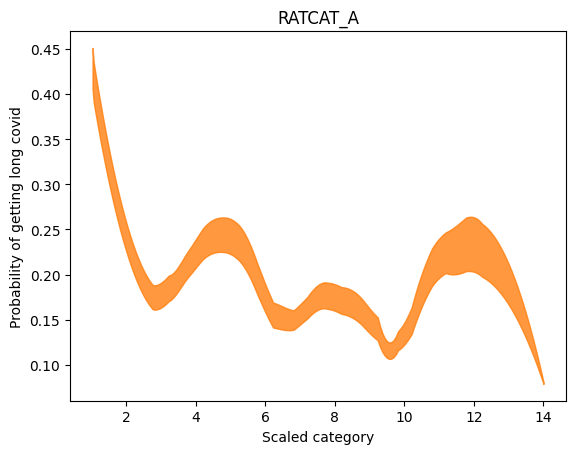

In [67]:
ax = az.plot_hdi(
    unscaled_cont.RATCAT_A, ## CHANGE
    idata_hier_chi.posterior["p"],
    hdi_prob=0.6,
    fill_kwargs={"color": "tab:orange", "alpha": 0.8},
)
ax.set_title("RATCAT_A")
ax.set_xlabel("Scaled category")
ax.set_ylabel("Probability of getting long covid")
plt.show()

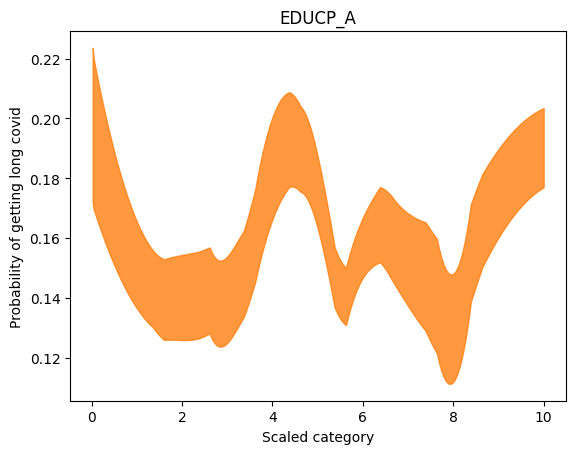

In [68]:
ax = az.plot_hdi(
    unscaled_cont.EDUCP_A, ## CHANGE
    idata_hier_chi.posterior["p"],
    hdi_prob=0.6,
    fill_kwargs={"color": "tab:orange", "alpha": 0.8},
)
ax.set_title("EDUCP_A")
ax.set_xlabel("Category")
ax.set_ylabel("Probability of getting long covid")
plt.show()